# B- Response Variable Wrangling (KMZ to Raster)

#### First, I had to install: gdal, rasterstats, shapely, rasterio, fiona... manually from binaries

In [1]:
import rasterstats
import numpy as np
from rasterstats import zonal_stats
import gdal
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

#### The purpose of this notebook is to show how to get a numpy array containing site locations from their original format, which was a Google Earth kmz file of oulines of each site.  This array is the response variable in the project.

####  To begin, we download the kmz file from Menze and Ur's Dataverse webpage using Selenium (the file can only be downloaded by clicking a download button):

In [1]:
'''
    Use chromedriver.exe in the current directory with selenium to go to data website for Menze and Ur 2012 article in Chrome.
    This code opens up a Chrome window and clicks the download button for Ur and Menze's site location kmz file.  Then, it closes
    the Chrome window when the download is complete (or if the file has previously been downloaded). 
'''
from selenium import webdriver
import os, time

#Set Chrome's download directory to the present working directory:
chromeOptions = webdriver.ChromeOptions()
pwd = %pwd
profile={"download.default_directory":pwd}
chromeOptions.add_experimental_option("prefs", profile)

#start up a Chrome window using the settings above and go to Menze and Ur's dataverse page:
driver = webdriver.Chrome(chrome_options=chromeOptions)
driver.get("https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/17731#724")

#Click download button containing site location kmz file:
driver.find_element_by_id("datasetForm:tabView:filesTable:3:j_idt724").click()

#While file is downloading (i.e. temp files are active), keep Chrome up; when the file is done downloading, close the window:
while True:
        if os.path.exists(pwd+'\menze-ur_khabur_sites-outlines.kmz.part'):
            time.sleep(10)
        elif os.path.exists(pwd+'\menze-ur_khabur_sites-outlines.kmz'):
            break
        else:
            time.sleep(10)
driver.close()

#### We would like to clip the site outlines in the kmz file of the site locations to a raster, and then transform them from shape outlines into array values.  The storage of these locations is fundamentally different from the other data types because they are stored as individual shapes with coordinates and geometry, not as values in an array-like format that covers the study area.  The zonal_stats() function from rasterstats can be used to clip shapes to a raster by setting the raster_out parameter to True.  Unfortunately, gdal doesn't support the kmz file format, so the first thing we need to do is convert the file into a format that can be used by gdal.  

### The first step is to convert the KMZ to a KML file by unzipping KMZ:

In [4]:
#First rename file extension .kmz to .zip
import os
os.renames('menze-ur_khabur_sites-outlines.kmz', 'menze.zip')

#Then, unzip menze.zip to the current directory to reveal the file 'doc.kml':
import zipfile
zipped = zipfile.ZipFile('menze.zip', 'r')
zipped.extractall()
zipped.close()

### In earlier attempts of this process, we found that the fact that the sites are stored as outlines causes a problem with our array output.  The problem is that we compute the intersection of the outline and the site raster, so we only catch the boundaries of the sites and miss the interiors.  We don't want this because we want our classifier to be able to predict the interior of sites, not just their edges.  An example of this output: masked_array output shows hollow sites, that is, blobs of "-- --" corresponding to the interior of the sites which should be filled.  

In [ ]:
    'mini_raster_array': masked_array(data =
   [[0 0 0 0 0 0 0 0 0 --]
   [0 0 -- -- 0 0 0 -- 0 0]
   [-- 0 -- -- -- -- -- -- -- 0]
   [-- 0 0 -- -- -- -- -- 0 0]
   [-- -- 0 0 -- -- -- -- 0 --]
   [-- -- -- 0 -- -- -- -- 0 --]
   [-- -- -- 0 -- -- -- -- 0 --]
   [-- -- -- 0 0 0 0 0 0 --]
   [-- -- -- 0 0 -- -- -- -- --]],

### Therefore, we need to convert the site outlines in the KML file from line features to polygon features so that the intersection will include the interior of the sites.  

###The kml file is reminiscent of html, and has opening and closing tags that indicate the geometry type.  Example:

In [ ]:
		<Placemark>
			<description>Digitizer Tool Line</description>
			<styleUrl>#line10</styleUrl>
			<LineString>
				<coordinates>
					39.8706552,36.74484027,0 39.8706552,36.74484027,...
                    ...
                    ... 0 39.87068397,36.74490767,0 39.8706552,36.74484027,0 
				</coordinates>
			</LineString>
		</Placemark>

### All we have to do is replace every "LineString" encoding with the encoding for defining a polygon from its outline.  This can be done programatically:

In [3]:
import fileinput
kml=open('doc.kml', 'r')
kmldata=kml.read()
kml.close()

newdata=kmldata.replace("<LineString>", "<Polygon><outerBoundaryIs><LinearRing>")
newdata1=newdata.replace("</LineString>", "</LinearRing></outerBoundaryIs></Polygon>")

f=open('fileout.kml', 'w')
f.write(newdata1)
f.close()

### Now we convert the KML file of polygons and convert it to Shapefile of Site Polygons with Grass 7.0.2 Command Line
(This should be run locally pointing to specific folders Grass and its projection data are saved to, following the same form as below for Jon's machine)

In [4]:
%%cmd
rem #Open up Grass 7.0.2 from command line and convert KML polyline features to Shapefile Polygons in folder devoted to WGS84 projection:
C:\"Program Files (x86)"\"Grass GIS 7.0.2"\grass70 C:\Users\Jon\Drive\Cleopythons\WGS84_1\Jon

rem #Import KML polylines 'fileout.kml' as a Grass layer "Line_Features"
v.in.ogr --overwrite input=C:\Users\Jon\Drive\Cleopythons\fileout.kml output=Line_Features

rem #Output Site Polygons as shapefile "Menze2.shp"
v.out.ogr -c --overwrite input=Line_Features output=C:\Users\Jon\Drive\Cleopythons format=ESRI_Shapefile output_layer=Menze2 output_type=boundary

rem #Exit Grass Command Prompt
exit

Microsoft Windows [Version 10.0.10240]
(c) 2015 Microsoft Corporation. All rights reserved.

C:\Users\Jon\Drive\Cleopythons>rem #Open up Grass 7.0.2 from command line and convert KML polyline features to Shapefile Polygons in folder devoted to WGS84 projection:

C:\Users\Jon\Drive\Cleopythons>C:\"Program Files (x86)"\"Grass GIS 7.0.2"\grass70 C:\Users\Jon\Drive\Cleopythons\WGS84_1\Jon
Microsoft Windows [Version 10.0.10240]
(c) 2015 Microsoft Corporation. All rights reserved.

C:\Users\Jon>
C:\Users\Jon>rem #Import KML polylines 'menze_kml.kml' as a Grass layer "Line_Features"

C:\Users\Jon>v.in.ogr --overwrite input=C:\Users\Jon\Drive\Cleopythons\fileout.kml output=Line_Features

C:\Users\Jon>
C:\Users\Jon>rem #Output Site Polygons as shapefile "Menze2.shp"

C:\Users\Jon>v.out.ogr -c --overwrite input=Line_Features output=C:\Users\Jon\Drive\Cleopythons format=ESRI_Shapefile output_layer=Menze2 output_type=boundary

C:\Users\Jon>
C:\Users\Jon>rem #Exit Grass Command Prompt

C:\Users\Jon

Cleaning up temporary files...
Starting GRASS GIS...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \ 
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ / 
       \____/_/ |_/_/  |_/____/____/   \____/___//____/  

Welcome to GRASS GIS 7.0.2
GRASS GIS homepage:                      http://grass.osgeo.org
This version running through:            Command Shell (C:\WINDOWS\system32\cmd.exe)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Check if OGR layer <Line Features> contains polygons...
   0%   2%   4%   6%   8%  10%  12%  14%  16%  18%  20%  22%  24%  26%  28%  30%  32%  34%  36%  38%  40%  4

### Another issue is that because the SRTM file was in the WGS84 projection, the affine transformation values are in degrees, which is not convenient for putting these mini-arrays into one array.  So I convert the projection of Menze2.shp to UTM 37N:

In [3]:
%%cmd
ogr2ogr -t_srs EPSG:32637 -s_srs EPSG:4326 Menze2_UTM37N.shp Menze2.shp

Microsoft Windows [Version 10.0.10240]
(c) 2015 Microsoft Corporation. All rights reserved.

C:\Users\Jon\Google Drive\Cleopythons>ogr2ogr -t_srs EPSG:32637 -s_srs EPSG:4326 Menze2_UTM37N.shp Menze2.shp

C:\Users\Jon\Google Drive\Cleopythons>

### Then, clip the site polygons to the Landsat clip of our study area (which is in the same projection).  Now, I will use zonal_stats to output the masked arrays.  I use all_touched = True, which means that every pixel that contains any portion of a site will be considered True, and not just pixels that are completely sites.  Setting raster_out = True, we get mini masked array for each site.  

In [17]:
%%time
stats = zonal_stats('Menze2_UTM37N.shp', 'landsat_clip.tif', all_touched = True, raster_out = True)

Wall time: 53 s


### This output is a list of 12746 dictionaries, with each dictionary corresponding to a site.  Each site has a mini masked array that shows where a site is present within a given subrange of the raster.   There is also an affine transformation that gives the position of the upper left corner of the mini array.  This can be used to put all of these mini-arrays together into one large array.   

###Here is an example of the output for one of the 12746 sites.  Notice that the interior is filled.  The mask portion of the masked_array object portion of the output will next be used to put all of the sites together into a single large array with correct positions.  

In [59]:
stats[46]

{'count': 27,
 'max': 0.0,
 'mean': 0.0,
 'min': 0.0,
 'mini_raster_affine': Affine(30.0, 0.0, 580875.0000000119,
       0.0, -30.0, 4049654.9999999916),
 'mini_raster_array': masked_array(data =
  [[-- -- -- 0 0 --]
  [-- -- 0 0 0 --]
  [-- -- 0 0 0 0]
  [-- 0 0 0 0 0]
  [0 0 0 0 0 0]
  [0 0 0 0 0 --]
  [-- -- -- 0 0 --]],
              mask =
  [[ True  True  True False False  True]
  [ True  True False False False  True]
  [ True  True False False False False]
  [ True False False False False False]
  [False False False False False False]
  [False False False False False  True]
  [ True  True  True False False  True]],
        fill_value = 999999),
 'mini_raster_nodata': -999}

### The affine transformation of each mini-array is in the same reference as the raster that the shapefile was clipped to:

In [18]:
stats[10]['mini_raster_affine']

Affine(30.0, 0.0, 577815.0000000119,
       0.0, -30.0, 4095554.9999999916)

### Gdal puts these values in a different order from rasterstats, but they give the same information:

In [19]:
landsat_clip = gdal.Open('landsat_clip.tif')
landsat_clip.GetGeoTransform()

(634515.0000000119, 30.0, 0.0, 4118024.9999999916, 0.0, -30.0)

### These six values are the width of each pixel, the height of each pixel (in this case, 30 meters), two values for the rotation of the image (0 if North is up), and the x and y coordinate of the Northwest corner of the array.  These will be used to put all of the mini-arrays together.  
### First, I need the X and Y UTM coordinates of the upper left corner of the landsat clip that I created the mini-arrays with.  These can be extracted with the GetGeotransform() method on the landsat clip.  These will be subtracted from each corresponding coordinate value of the affine transformation for each mini-array.  They will then be divided by the width/height of the pixels (30m), and transformed to integer values to give array positions.  

In [20]:
clip_x = landsat_clip.GetGeoTransform()[0]
clip_y = landsat_clip.GetGeoTransform()[3]

### For each mini-raster, we only need the mask values and the transformation, and we wish to reverse the True/False values within the mask because False actually corresponds to a site being present in an array position. 
### I extract just the information I need from the output, which is the mask and the affine transformation.  I also reverse the mask and convert the UTM coordinates to array position indexes.  

In [21]:
# I first create an empty array to append results to.  
mini_arrays = []
# Next I iterate over the list of results and append just a list of the reversed mask and array indexes for each mini-array.  
for i in stats: 
    affine = i['mini_raster_affine']  # the array of affine transformation values in the dictionary
    col_idx = np.int((affine[2] - clip_x)/30)        # Subtract the affine coordinate value from the image corner values and 
    row_idx = np.int((clip_y - affine[5])/30)        #    divide by the pixel width to get an array position index for x and y.  
    # The subtraction is reversed in the y case because I want the y-index descending
    mini_arrays.append([row_idx, col_idx, np.invert(i['mini_raster_array'].mask)])

### Here is an example of the output:

In [22]:
mini_arrays[90]

[191, -1706, array([[False,  True,  True,  True,  True, False, False, False],
        [False,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True, False, False],
        [False, False,  True,  True,  True,  True, False, False],
        [False,  True,  True,  True,  True,  True, False, False],
        [False, False,  True,  True, False, False, False, False]], dtype=bool)]

### Notice that we get negative index values.  That is because some of the polygons are outside of the image that I intersected with (that is, our study area).  I will remove any polygons that are out of bounds before proceeding.
### Out of bounds to the North and West are simple: these are negative values.  To figure out which polygons are out of bounds to the South or East is more tricky.  These will have indices that are greater than or equal to the dimensions of the landsat_clip array.  

In [23]:
# Find the maximum dimensions
clip_max_row = np.shape(landsat_clip.ReadAsArray())[0]
clip_max_col = np.shape(landsat_clip.ReadAsArray())[1]

In [24]:
print("Number of sites before removing out of bounds ones: " + str(len(mini_arrays)))

new_mini_arrays = []
for i in mini_arrays:
    shape = np.shape(i[2])
    height = shape[0]
    width = shape[1]   
    row_idx = i[0]
    col_idx = i[1]
    
    # Check if out of bounds left
    if col_idx + width <= 0: 
        continue                         # Completely out of bounds, no portion of site is in array.  Next array
    elif col_idx < 0:                    # Straddles the border of the study area
        i[2] = i[2][:,-col_idx:]         # Take only the overlapping portion
        i[1] = 0                         # Update column coordinate
        col_idx = 0
    
    # Check if out of bounds top
    if row_idx + height <= 0: 
        continue
    elif row_idx < 0:
        i[2] = i[2][-row_idx:,:]
        i[0] = 0
        row_idx = 0
        
    # Check if out of bounds right
    if col_idx >= clip_max_col: 
        continue
    elif col_idx + width >= clip_max_col:  # Overlapping right edge
        i[2] = i[2][:,:(clip_max_col - col_idx)]
    
    # Check if out of bounds bottom
    if row_idx >= clip_max_row: 
        continue
    elif row_idx + height >= clip_max_row:  # Overlapping bottom edge
        i[2] = i[2][:(clip_max_row - row_idx),:]
    
    # If the iteration made it to this point, some portion of the mini-raster is in bounds and has been trimmed
    #     if it overlapped, so it can be appended.  
    new_mini_arrays.append(i)
     
    
mini_arrays = new_mini_arrays
    
print("Number of sites after removing out of bounds ones: " + str(len(mini_arrays)))

Number of sites before removing out of bounds ones: 12746
Number of sites after removing out of bounds ones: 9358


### Here is an example of an array that overlapped the left boundary.  Notice the flat left edge of the site boundary.  

In [25]:
mini_arrays[10]

[697, 0, array([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True, False],
        [ True,  True, False],
        [ True, False, False]], dtype=bool)]

### Now the empty landsat_clip array can be used to add all of the mini_arrays to create an array of all of the sites

###I need to pad each mini-array with False above, below, to the right, and to the left to make it the size of land_sat_clip, and pad these False values in a way that corresponds with the mini-array's position in landsat_clip.  To do this, I use the row and column indices for the top and left pads, and I subtract these indices and the widths or heights to form the bottom pads.  This produces a full-sized array for each site that has the same dimensions as the empty landsat clip.  
### These arrays are too large (9325 arrays that are 2603 by 5638) to store in an list (trying causes memory errors), so at each step I use a logical_or() function to combine the new boolean arrays one-by-one to a running aggregation.  OR takes care of overlapping arrays nicely. 

In [26]:
%%time
padded_mini_arrays = []
# Empty array of the study area that I add the sites to
site_array = landsat_clip.ReadAsArray()

for i in (mini_arrays):
    # Find the indexes of the upper left corners of the mini-array
    row_idx = i[0]
    col_idx = i[1]
    
    # Find the dimensions of the mini-array
    shape = np.shape(i[2])
    height = shape[0]
    width = shape[1]
   
    # Add padding to each mini-array to fit into the correct portion of the study area array
    
    # First, have to define how much to pad on each side based on the position of the corner and the dimensions
    #      of the mini-array
    top_pad    = row_idx
    bottom_pad = clip_max_row - row_idx - height
    left_pad   = col_idx
    right_pad  = clip_max_col - col_idx - width
    
    # Next, pad the array
    padded = np.pad(i[2], [[top_pad, bottom_pad],[left_pad, right_pad]], 'constant', constant_values=False)
    
    # Finally, add the padded array to the ongoing copy of the study area
    site_array = np.logical_or(site_array, padded)

Wall time: 3min 51s


### And finally we have our response variable in a tidy array!  It contains 871496 True values.  

In [27]:
np.sum(site_array)

871496

### Here is what the study area looks like.  Sites are white:

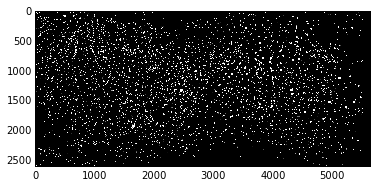

In [34]:
plt.imshow(site_array, cmap = 'gray')

###Zooming in:

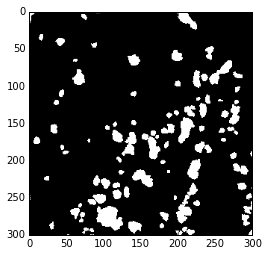

In [38]:
plt.imshow(site_array[200:500,500:800], cmap = 'gray')

### Save this array so that it can be re-used in other notebooks without re-creating it

In [29]:
np.save('sites.npy', site_array)

### Resources
rasterstats:
https://pypi.python.org/pypi/rasterstats
Rasterize a shapefile:
http://gis.stackexchange.com/questions/151339/rasterize-a-shapefile-with-geopandas-or-fiona-python
Some clues about the Affine values from http://nbviewer.ipython.org/github/perrygeo/python-raster-stats/blob/master/docs/notebooks/Integrating%20with%20GeoPandas%20and%20Numpy.ipynb:
